# Capstone - Travel Recommender (WanderLust)

## Notebook 3 of 4
- Notebook 1: Introduction, Scraping
- Notebook 2: Combining Datasets, Data Cleaning, EDA and Base Model
- **Notebook 3: NLP (Sentiment Analysis), Feature Engineering + EDA + Model(With Feature Engineering) Conclusion + Recommendations**
- Notebook 4: Google Cloud + Streamlit

## Sentiment Analysis on the user review
1. The rational to look into the user reviews in particular the Sentiment Analysis to get a sense of the customer's feelings. This is especially important for companies because one of the basic lessons that all companies should follow is that success lies in the hands of their customers. Understanding how those customers feel about your product or service is essential to financial survival and prosperity. [Link](https://www.repustate.com/blog/product-review-sentiment-analysis/)
2. Below are a few reasons why consumers writes a review [Link](https://business.trustpilot.com/reviews/learn-from-customers/why-do-people-write-reviews-what-our-research-revealed)
- Venting frustrations if the experience was negative
- Praising and helping the company if the experience was positive
- Having a need to express oneself and feel empowered in doing so
- Wanting to be recognized or acknowledged for having certain knowledge/taste
- Feeling part of a community and wanting to give back
3. 75% of people trust a business after seeing a positive review
4. 95% of shoppers read the reviews posted on business reviews before making a purchase.
5. 97% of consumers report that the customer reviews they read influence their purchasing decision. [Link](https://websitebuilder.org/blog/online-review-statistics/)
- Thus, user review actually plays an important role for attractions/activities. 
- However, rather than displaying the reviews as text for user to read (as it could be quite time consuming to comb through tens of reviews for each activities), sentiment analysis will be formed as part of Feature Engineering to incorporate with the model thus providing attractions/activities with good ratings and reviews.
4. For TripAdvisor website, it is not possible to rate and activity without writing a review.   
   Thus, those without reviews will not have any ratings as well.

## Combining the `attractions_canada` dataset with `attractions_review` dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics.pairwise import cosine_similarity

from transformers import pipeline

from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
reviews = pd.read_csv('datasets/attractions_review.csv',index_col='Unnamed: 0')

In [3]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33925 entries, 0 to 33924
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attraction_id  33925 non-null  int64  
 1   rating         33925 non-null  float64
 2   review         33925 non-null  object 
 3   review_date    33925 non-null  object 
 4   user           33925 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
att_canada = pd.read_csv('datasets/attractions_canada.csv',index_col='Unnamed: 0')

In [5]:
att_canada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1705 entries, 0 to 1783
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   attraction_id              1705 non-null   int64  
 1   name                       1705 non-null   object 
 2   country                    1705 non-null   object 
 3   province                   1705 non-null   object 
 4   city_name                  1705 non-null   object 
 5   rating                     1705 non-null   float64
 6   group_reviews              797 non-null    object 
 7   attraction                 1705 non-null   object 
 8   description                1705 non-null   object 
 9   duration                   1704 non-null   object 
 10  images                     1705 non-null   object 
 11  accommodation              1705 non-null   int64  
 12  adventure                  1705 non-null   int64  
 13  air tour                   1705 non-null   int64

In [6]:
reviews = reviews.merge(att_canada[['attraction_id','name']],how='left',on='attraction_id')

In [7]:
reviews_canada = reviews.dropna(subset=['name'])

In [8]:
reviews_canada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13610 entries, 0 to 33591
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attraction_id  13610 non-null  int64  
 1   rating         13610 non-null  float64
 2   review         13610 non-null  object 
 3   review_date    13610 non-null  object 
 4   user           13610 non-null  object 
 5   name           13610 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 744.3+ KB


In [9]:
reviews_canada['attraction_id'].nunique()

804

**Observation:**
- There are 13610 for 804 activities, the remaining activites does not have a review.

In [10]:
reviews_canada.to_csv('./datasets/reviews_canada.csv')

## Preprocessing of reviews

- Check the percentage of emojis in the reviews

In [11]:
import emoji
import regex

def split_count(text):
    character = np.nan
    # emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            # emoji_list.append(word)
            character = word
    
    return character

In [12]:
emojis = reviews_canada['review'].apply(split_count)

In [13]:
emojis.notna().sum()/len(emojis)*100

0.5510653930933138

- Since there are only less than 1% of reviews that contains emojis, the regex used on the reviews will only extract text out to reduce noise.

In [14]:
# Creating a Regex function to select only text .
def split_it(text):
    x = re.findall("[a-zA-Z]+", str(text))
    return(' '.join(x))

In [15]:
# Creating a new column 'review_re'
reviews_canada['review_re'] = reviews_canada['review'].apply(split_it)

C:\Users\calerlime\AppData\Local\Temp\ipykernel_23156\491019440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_canada['review_re'] = reviews_canada['review'].apply(split_it)


In [16]:
reviews_canada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13610 entries, 0 to 33591
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   attraction_id  13610 non-null  int64  
 1   rating         13610 non-null  float64
 2   review         13610 non-null  object 
 3   review_date    13610 non-null  object 
 4   user           13610 non-null  object 
 5   name           13610 non-null  object 
 6   review_re      13610 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 850.6+ KB


In [17]:
reviews_canada.reset_index(inplace=True)

In [18]:
reviews_canada.rename(columns={'index': 'review_id'}, inplace=True)

C:\Users\calerlime\AppData\Local\Temp\ipykernel_23156\214066078.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_canada.rename(columns={'index': 'review_id'}, inplace=True)


In [19]:
reviews_canada.head()

,review_id,attraction_id,rating,review,review_date,user,name,review_re
0,0,0,5.0,Another 'Dave' Guides us Around Vancouver. Lan...,"March 14, 2019",drew22perthaustralia,vancouver_city_sightseeing_tour,Another Dave Guides us Around Vancouver Landse...
1,1,0,5.0,Fantastic way to explore VC. An easy way to ex...,"March 1, 2019",marc_h,vancouver_city_sightseeing_tour,Fantastic way to explore VC An easy way to exp...
2,2,0,5.0,This was a great half day tour!. Was there for...,"February 28, 2019",maggiehand,vancouver_city_sightseeing_tour,This was a great half day tour Was there for b...
3,3,0,5.0,All the main attractions. Scott was our lovely...,"December 19, 2018",catherine255066,vancouver_city_sightseeing_tour,All the main attractions Scott was our lovely ...
4,4,0,5.0,Excellent Vancouver Sightseeing Tour. We would...,"November 29, 2018",gearjamkw,vancouver_city_sightseeing_tour,Excellent Vancouver Sightseeing Tour We would ...


## Hugging Face Transformer: [cardiffnlp/twitter-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)
1. Why chose this model: Since Twitter has a mixture of noisy text and formal text
2. This transformer is able to perform the following 
- Emotion Recognition
- Sentiment Analysis
3. From the analysis, it is able to produce 3 output (Positive, Neutral and Negative) sentiments.

In [20]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [21]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

def preprocess(text):
    new_text = [] 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

('cardiffnlp/twitter-roberta-base-sentiment\\tokenizer_config.json',
 'cardiffnlp/twitter-roberta-base-sentiment\\special_tokens_map.json',
 'cardiffnlp/twitter-roberta-base-sentiment\\vocab.json',
 'cardiffnlp/twitter-roberta-base-sentiment\\merges.txt',
 'cardiffnlp/twitter-roberta-base-sentiment\\added_tokens.json',
 'cardiffnlp/twitter-roberta-base-sentiment\\tokenizer.json')

In [22]:
negative=[]
neutral=[]
positive=[]
for text in tqdm(reviews_canada['review_re'], desc = 'tqdm() Progress Bar'):
    index = 0
    if index < len(reviews_canada):
        text = preprocess(text)
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        negative.append(scores[0])
        neutral.append(scores[1])
        positive.append(scores[2])
        index +=1
reviews_canada['negative'] = pd.DataFrame(negative)
reviews_canada['neutral'] = pd.DataFrame(neutral)
reviews_canada['positive'] = pd.DataFrame(positive)

tqdm() Progress Bar: 100%|███████████████████████████████████████████████████████| 13610/13610 [15:41<00:00, 14.46it/s]
C:\Users\calerlime\AppData\Local\Temp\ipykernel_23156\946832265.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_canada['negative'] = pd.DataFrame(negative)
C:\Users\calerlime\AppData\Local\Temp\ipykernel_23156\946832265.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_canada['neutral'] = pd.DataFrame(neutral)
C:\Users\calerlime\AppData\Local\Temp\ipykernel_23156\94

In [23]:
reviews_canada_re = reviews_canada.copy()

In [24]:
reviews_canada_re.to_csv('./datasets/reviews_canada_re.csv')

In [25]:
reviews_canada_re.head()

,review_id,attraction_id,rating,review,review_date,user,name,review_re,negative,neutral,positive
0,0,0,5.0,Another 'Dave' Guides us Around Vancouver. Lan...,"March 14, 2019",drew22perthaustralia,vancouver_city_sightseeing_tour,Another Dave Guides us Around Vancouver Landse...,0.038879,0.880723,0.080399
1,1,0,5.0,Fantastic way to explore VC. An easy way to ex...,"March 1, 2019",marc_h,vancouver_city_sightseeing_tour,Fantastic way to explore VC An easy way to exp...,0.001225,0.012081,0.986694
2,2,0,5.0,This was a great half day tour!. Was there for...,"February 28, 2019",maggiehand,vancouver_city_sightseeing_tour,This was a great half day tour Was there for b...,0.001659,0.009085,0.989256
3,3,0,5.0,All the main attractions. Scott was our lovely...,"December 19, 2018",catherine255066,vancouver_city_sightseeing_tour,All the main attractions Scott was our lovely ...,0.001289,0.012177,0.986533
4,4,0,5.0,Excellent Vancouver Sightseeing Tour. We would...,"November 29, 2018",gearjamkw,vancouver_city_sightseeing_tour,Excellent Vancouver Sightseeing Tour We would ...,0.003274,0.041389,0.955338


In [26]:
pd.DataFrame(reviews_canada_re.groupby('attraction_id')['attraction_id'].count().sort_values(ascending=False))

,attraction_id
attraction_id,
81,399
5,367
70,293
14,246
583,244
...,...
609,1
1796,1
1801,1


### Check if the reviews are the same as sentiment analysis (Analyse some random reviews to check its performance)
- Evaluating if the model classifies the correct sentiment for the reviews

In [27]:
# Comparing to the 'negative': 0.400131, 'neutral':0.433629 , 'positive':0.166239 for this review
# The reviews is a neutral sentiment since they mentioned that 'the tour was ok'.
print(reviews_canada_re.iloc[18]['review'])
print(f"User Rating: {reviews_canada_re.iloc[18]['rating']}")
print(f"Negative probability: {reviews_canada_re.iloc[18]['negative']}")
print(f"Neutral probability: {reviews_canada_re.iloc[18]['neutral']}")
print(f"Positive probability: {reviews_canada_re.iloc[18]['positive']}")

Ok tour to kill time prior to flight. We took this tour to kill time prior to flight home. The tour was ok, not outstanding. We really could care less about downtown Vancouver which looked just like any other large downtown any where else. The driver/tour guide saw himself as funny, a couple...
User Rating: 3.0
Negative probability: 0.40013137459754944
Neutral probability: 0.43362948298454285
Positive probability: 0.16623908281326294


In [28]:
# Comparing to the 'negative': 0.00145, 'neutral':0.01891 , 'positive':0.9796 for this review
# The reviews is a positive sentiment since they mentioned that 'good overview'. 
print(reviews_canada_re.iloc[33]['review'])
print(f"User Rating: {reviews_canada_re.iloc[33]['rating']}")
print(f"Negative probability: {reviews_canada_re.iloc[33]['negative']}")
print(f"Neutral probability: {reviews_canada_re.iloc[33]['neutral']}")
print(f"Positive probability: {reviews_canada_re.iloc[33]['positive']}")

A good overview of Vancouver. Stayed an extra day after our cruise so had a limited time to visit. This was a great way to see the highlights of the city in about 5 hours total. They picked up us and dropped us off at the hotel.
User Rating: 4.0
Negative probability: 0.0014532224740833044
Neutral probability: 0.018916336819529533
Positive probability: 0.9796305298805237


In [29]:
# # Comparing to the 'negative': 0.09767, 'neutral':0.37122 , 'positive':0.5311 for this review
# This review is a negative reivew: 'meal was rushed','buffet very average', 'lovely guide'
# The sentiment analysis for this is incorrect
print(reviews_canada_re.iloc[767]['review']) 
print(f"User Rating: {reviews_canada_re.iloc[767]['rating']}")
print(f"Negative probability: {reviews_canada_re.iloc[767]['negative']}")
print(f"Neutral probability: {reviews_canada_re.iloc[767]['neutral']}")
print(f"Positive probability: {reviews_canada_re.iloc[767]['positive']}")

Please read on re helicopter section of this tour.. Our day was with a lovely guide by the name of Alayija and we can not fault him and what he delivered however be aware that the meal is rushed and the restaurant could not wait for us to move. Buffet very average! The helicopter...
User Rating: 2.0
Negative probability: 0.09767662733793259
Neutral probability: 0.371220201253891
Positive probability: 0.5311030745506287


In [30]:
# # Comparing to the 'negative': 0.646042, 'neutral':0.322245 , 'positive':0.031713 for this review
# This review is a negative reivew: 'nobody', 'lost 48€' (Negative sentiment)
print(reviews_canada_re.iloc[4716]['review'])
print(f"User Rating: {reviews_canada_re.iloc[4716]['rating']}")
print(f"Negative probability: {reviews_canada_re.iloc[4716]['negative']}")
print(f"Neutral probability: {reviews_canada_re.iloc[4716]['neutral']}")
print(f"Positive probability: {reviews_canada_re.iloc[4716]['positive']}")

There pas nobody.. I came at the meeting point at the good hour. There was nobody and nobody in the place knew this activity. So I've lost 48€
User Rating: 1.0
Negative probability: 0.6460418105125427
Neutral probability: 0.3222449719905853
Positive probability: 0.03171330317854881


In [31]:
# # Comparing to the 'negative': 0.00274, 'neutral':0.0088 , 'positive':0.9884 for this review
# This review is a positive reivew: 'So much fun'
print(reviews_canada_re.iloc[13580]['review'] ) 
print(f"User Rating: {reviews_canada_re.iloc[13580]['rating']}")
print(f"Negative probability: {reviews_canada_re.iloc[13580]['negative']}")
print(f"Neutral probability: {reviews_canada_re.iloc[13580]['neutral']}")
print(f"Positive probability: {reviews_canada_re.iloc[13580]['positive']}")

So much fun!. OMG, so going on a Segway was on my bucket list for 2018, and unfortunately I ran out of weekends. Started off 2019 in Canada for my birthday with a Segway Tour! I was so excited to have found this. The Distillery District is a...
User Rating: 5.0
Negative probability: 0.0027410294860601425
Neutral probability: 0.008826837874948978
Positive probability: 0.9884321093559265


**Observation:**
- Additional verification of the Hugging Face Model was done off the code notebook and found that the model has good performance to analyse the sentiment analysis. Thus, the assigned probability for each review was used in the Feature Engineering.

## Feature Engineering - Rating X Sentiment

- Activities that have cosine similarity with other activities are not enough to justify to customers of this recommendation system. 
- Since this recommender system aims to provides the best experience with their favourite types of activities.
- Based on the checks on the ratings of each review does not have similar score as sentiments, a new feature combines both the rating and sentiment to account for any discrepancy. (E.g. Someone might give a 5.0 review since they are very happy with the activity but still has some comments on areas of improvement which through the sentiment analysis might provide a neutral sentiment) (Thus, this would have a 1.0 on sentiment analysis score)

|User Ratings| Sentiment Score|
|---|---|
|Range from 1 to 5| Positive = 2, Neutral = 1 Negative = 0.5|

E.g. Highest score = 10 (e.g. rating = 5, sentiment score = 5)  
E.g. Lowest score = 0.5 (e.g. rating = 1, sentiment score = 0.5)

In [32]:
# Compare the probability scores of each sentiment and the largest probability to be returned in the new column 'sentiment'
reviews_canada_re['sentiment'] = reviews_canada_re[['negative','neutral', 'positive']].idxmax(axis=1)

In [33]:
# Mapping the values 0.5 for Negative sentiments, 1 for Neutral sentiments, 2 for Positive sentiments
reviews_canada_re['sentiment'] = reviews_canada_re['sentiment'].map({'negative':0.5,'neutral':1,'positive':2})

In [34]:
# Multiply the user rating and sentiment values
reviews_canada_re['rating_senti'] = reviews_canada_re['rating']*reviews_canada_re['sentiment']

In [35]:
reviews_canada_re.head()

,review_id,attraction_id,rating,review,review_date,user,name,review_re,negative,neutral,positive,sentiment,rating_senti
0,0,0,5.0,Another 'Dave' Guides us Around Vancouver. Lan...,"March 14, 2019",drew22perthaustralia,vancouver_city_sightseeing_tour,Another Dave Guides us Around Vancouver Landse...,0.038879,0.880723,0.080399,1.0,5.0
1,1,0,5.0,Fantastic way to explore VC. An easy way to ex...,"March 1, 2019",marc_h,vancouver_city_sightseeing_tour,Fantastic way to explore VC An easy way to exp...,0.001225,0.012081,0.986694,2.0,10.0
2,2,0,5.0,This was a great half day tour!. Was there for...,"February 28, 2019",maggiehand,vancouver_city_sightseeing_tour,This was a great half day tour Was there for b...,0.001659,0.009085,0.989256,2.0,10.0
3,3,0,5.0,All the main attractions. Scott was our lovely...,"December 19, 2018",catherine255066,vancouver_city_sightseeing_tour,All the main attractions Scott was our lovely ...,0.001289,0.012177,0.986533,2.0,10.0
4,4,0,5.0,Excellent Vancouver Sightseeing Tour. We would...,"November 29, 2018",gearjamkw,vancouver_city_sightseeing_tour,Excellent Vancouver Sightseeing Tour We would ...,0.003274,0.041389,0.955338,2.0,10.0


In [36]:
reviews_canada_re.shape

(13610, 13)

In [37]:
# Number of attractions with reviews
reviews_canada_re['attraction_id'].nunique()

804

In [38]:
# The median value of rating_sentiment is at 10.0. This is understandable since the user ratings and sentiment value are almost max for most reviews.
reviews_canada_re['rating_senti'].median()

10.0

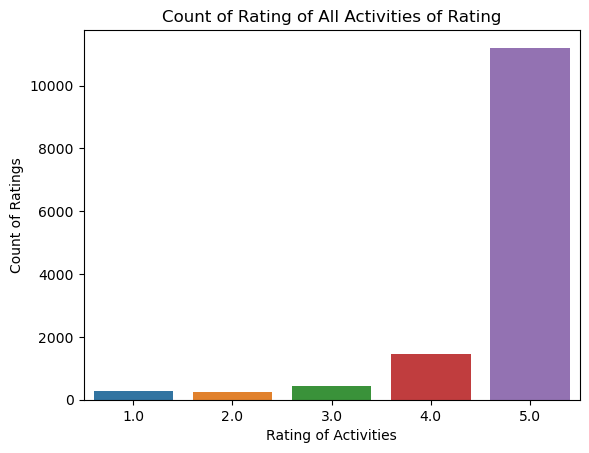

In [39]:
# Plot of Count of Rating of All Activities with user reviews
sns.countplot(data = reviews_canada_re, x = 'rating')
plt.title('Count of Rating of All Activities of Rating')
plt.xlabel("Rating of Activities")
plt.ylabel("Count of Ratings");

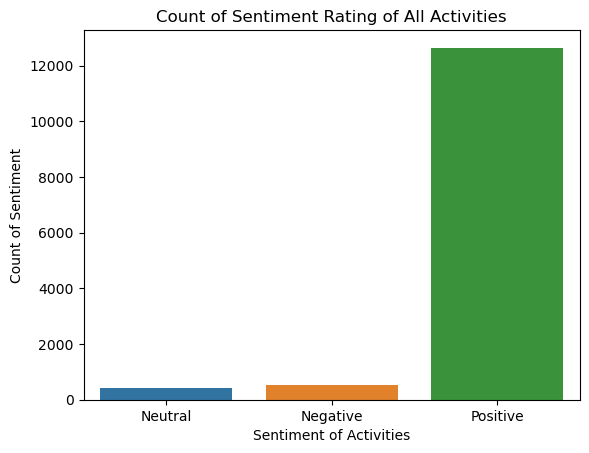

In [40]:
sentiment = reviews_canada_re.copy()
sentiment['senti_name'] = sentiment['sentiment'].map({0.5:'Negative',1: 'Neutral',2:'Positive'})
# Plot of Count of Rating of All Activities with user reviews
sns.countplot(data = sentiment, x = 'senti_name', order = sentiment['senti_name'].value_counts(ascending=True).index)
plt.title('Count of Sentiment Rating of All Activities')
plt.xlabel("Sentiment of Activities")
plt.ylabel("Count of Sentiment");

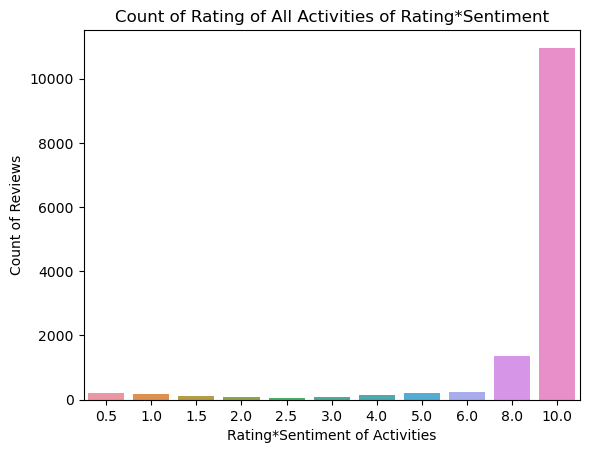

In [41]:
# Plot of Count of Rating of All Activities of Rating* Sentiment
sns.countplot(data = reviews_canada_re, x = 'rating_senti')
plt.title('Count of Rating of All Activities of Rating*Sentiment')
plt.xlabel("Rating*Sentiment of Activities")
plt.ylabel("Count of Reviews");

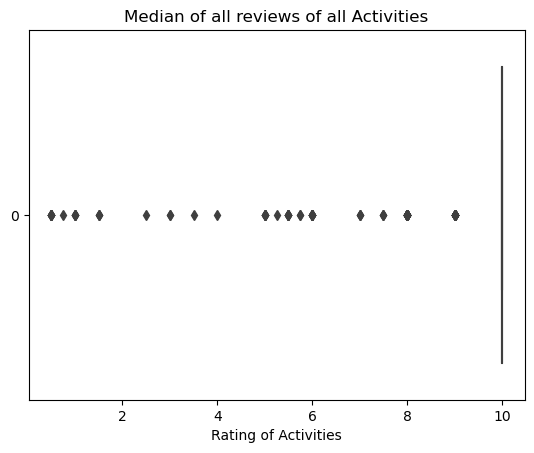

In [42]:
# Plot of Median of all reviews of all Activities
sns.boxplot(reviews_canada_re.groupby('attraction_id')['rating_senti'].median(), orient='h')
plt.title('Median of all reviews of all Activities')
plt.xlabel("Rating of Activities");

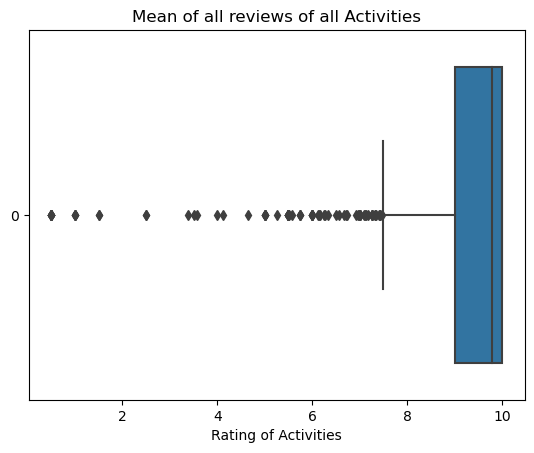

In [43]:
# Plot of Mean of all reviews of all Activities
sns.boxplot(reviews_canada_re.groupby('attraction_id')['rating_senti'].mean(), orient='h')
plt.title('Mean of all reviews of all Activities')
plt.xlabel("Rating of Activities");

**Observation**
- The rating, sentiment analysis, rating*sentiment value are heavily left-skewed.
- The mean of all reviews of all Activities are centered around between 9 to 10.
- The median of all reviews all Activities are centered around 10.

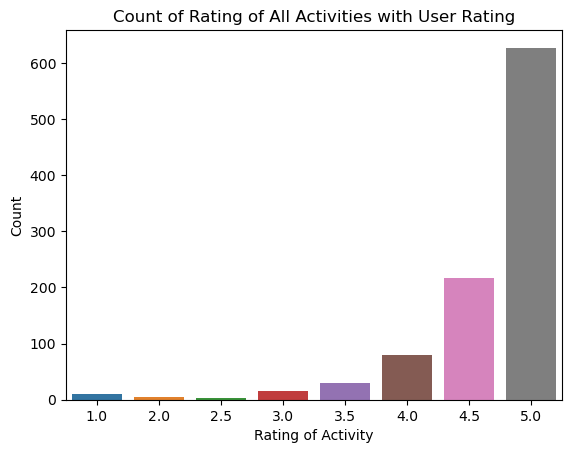

In [44]:
# Plot of Count of Rating of All Activities with user rating
sns.countplot(data = att_canada[att_canada['rating'] != -1], x = 'rating')
plt.title('Count of Rating of All Activities with User Rating')
plt.xlabel("Rating of Activity")
plt.ylabel("Count");

**Observation**
- From this graph, it is observed that most of the attractions has a rating of either 5.0 or -1.0.
- The original dataset has assigned -1 to all activities that does not have any rating. (which has been excluded from this graph)

In [45]:
# There are only 804 attractions/activities that has reviews
reviews_canada_re['attraction_id'].nunique()

804

In [46]:
# Group all the ratings into a new dataframe by the average rating of all the reviews.
reviews_grp_senti = reviews_canada_re.groupby(by = 'attraction_id')[['attraction_id','rating_senti']].mean()

In [47]:
reviews_grp_senti.reset_index(drop=True, inplace=True)

In [48]:
# Merge the group user ratings and sentiment values with main dataframe
att_canada_ratesen = att_canada.merge(reviews_grp_senti, how='left', on='attraction_id') 

In [49]:
# Number of attractions without any reviews
att_canada_ratesen['rating_senti'].isna().sum()

901

In [50]:
rating = att_canada_ratesen.copy()

In [51]:
import math
rating['with_rating'] = ['No' if (math.isnan(i)) else 'Yes' for i in rating['rating_senti']]

In [52]:
rating['with_rating']

0       Yes
1       Yes
2       Yes
3       Yes
4       Yes
       ... 
1700    Yes
1701    Yes
1702     No
1703     No
1704     No
Name: with_rating, Length: 1705, dtype: object

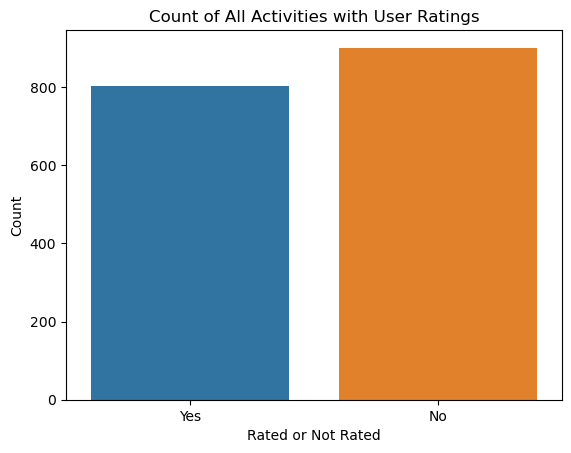

In [53]:
# Plot of Count of Rating of All Activities with user rating
sns.countplot(data = rating, x = 'with_rating')
plt.title('Count of All Activities with User Ratings')
plt.xlabel("Rated or Not Rated")
plt.ylabel("Count");

In [54]:
att_canada_ratesen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1705 entries, 0 to 1704
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   attraction_id              1705 non-null   int64  
 1   name                       1705 non-null   object 
 2   country                    1705 non-null   object 
 3   province                   1705 non-null   object 
 4   city_name                  1705 non-null   object 
 5   rating                     1705 non-null   float64
 6   group_reviews              797 non-null    object 
 7   attraction                 1705 non-null   object 
 8   description                1705 non-null   object 
 9   duration                   1704 non-null   object 
 10  images                     1705 non-null   object 
 11  accommodation              1705 non-null   int64  
 12  adventure                  1705 non-null   int64  
 13  air tour                   1705 non-null   int64

In [55]:
# Impute the median 'rating_senti' value to the attractions without any reviews
att_canada_ratesen['rating_senti'].median()

9.794559293922521

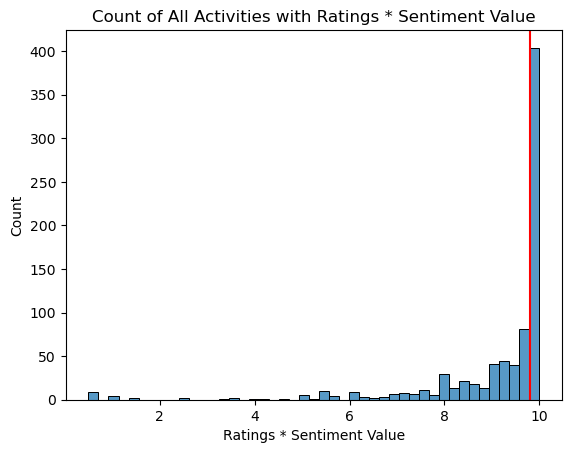

In [56]:
# Plot of Count of Rating*Sentiment Value of All Activities with Ratings_Sentiment Value
sns.histplot(data = att_canada_ratesen, x = 'rating_senti')
plt.axvline(x = att_canada_ratesen['rating_senti'].median(), color = 'r', label = 'axvline - Median Value')
plt.title('Count of All Activities with Ratings * Sentiment Value')
plt.xlabel("Ratings * Sentiment Value")
plt.ylabel("Count");

In [57]:
# Impute the median ratings to activities that does not have any reviews
att_canada_ratesen['rating_senti'].fillna(value=att_canada_ratesen['rating_senti'].median(), inplace=True)

In [58]:
att_canada_ratesen['rating_senti'].tail()

1700    9.814815
1701    5.500000
1702    9.794559
1703    9.794559
1704    9.794559
Name: rating_senti, dtype: float64

In [59]:
att_canada_ratesen.head()

,attraction_id,name,country,province,city_name,rating,group_reviews,attraction,description,duration,...,nature,park,photography,rental,sea tour,sightseeing,transport,wildlife,brewery/winery/distillery,rating_senti
0,0,vancouver_city_sightseeing_tour,canada,british_columbia,vancouver,4.5,Another 'Dave' Guides us Around Vancouver. Lan...,https://tripadvisor.ca/AttractionProductDetail...,A half-day sightseeing tour of Vancouver is th...,3h 30m,...,0,1,0,0,0,1,0,0,0,8.754386
1,1,vancouver_to_victoria_and_butchart_gardens_tou...,canada,british_columbia,vancouver,5.0,Canada. I was there in 2004 and below it only ...,https://tripadvisor.ca/AttractionProductDetail...,"Relish stunning coastal mountain vistas, sheer...",13h,...,0,1,0,0,1,1,0,0,0,9.157303
2,2,quebec_city_and_montmorency_falls_day_trip_fro...,canada,quebec,montreal,4.5,Interested City of Canada. Quebec is our belov...,https://tripadvisor.ca/AttractionProductDetail...,Discover Québec City history on a trip from Mo...,12h,...,0,0,0,0,0,1,0,0,0,8.007463
3,3,niagara_falls_day_trip_from_toronto,canada,ontario,toronto,5.0,Great day. It was an amazing day. The falls ar...,https://tripadvisor.ca/AttractionProductDetail...,The spectacular Niagara Falls lie just south o...,9h 30m,...,0,0,0,0,1,1,0,0,1,8.333333
4,4,"best_of_niagara_falls_tour_from_niagara_falls,...",canada,ontario,niagara_falls,5.0,"Valentine's Trip. Chris was a wonderful guide,...",https://tripadvisor.ca/AttractionProductDetail...,The Canadian side of Niagara Falls offers some...,4â€“5 hours,...,0,0,0,0,1,1,0,0,0,9.608108


### Perform a minmax scaler on the column `rating_senti`

In [60]:
# Perform minmax scaler on the column 'rating_senti'
minmax = MinMaxScaler()
att_canada_ratesen[['rating_senti']] = minmax.fit_transform(att_canada_ratesen[['rating_senti']])
print(att_canada_ratesen['rating_senti'])

0       0.868883
1       0.911295
2       0.790259
3       0.824561
4       0.958748
          ...   
1700    0.980507
1701    0.526316
1702    0.978375
1703    0.978375
1704    0.978375
Name: rating_senti, Length: 1705, dtype: float64


In [61]:
att_canada_ratesen['rating_senti'].describe()

count    1705.000000
mean        0.943794
std         0.125847
min         0.000000
25%         0.978375
50%         0.978375
75%         0.978375
max         1.000000
Name: rating_senti, dtype: float64

In [62]:
# A limit of less than 0.6 was set to make sure the only those with good reviews and ratings are recommended for our system.
# This value has to be adjusted in future with more ratings and reviews
# Thus, this would filter out 52 activities.
att_canada_ratesen[(att_canada_ratesen['rating_senti'] < 0.6)]

,attraction_id,name,country,province,city_name,rating,group_reviews,attraction,description,duration,...,nature,park,photography,rental,sea tour,sightseeing,transport,wildlife,brewery/winery/distillery,rating_senti
83,86,whale_watching_tour_from_granville_island_in_v...,canada,british_columbia,vancouver,4.5,Overall a bit disappointing.. humpbacks and se...,https://tripadvisor.ca/AttractionProductDetail...,"Watch for orcas, humpback whales, seals, and o...",4h,...,0,0,0,0,1,0,0,1,0,0.105263
128,133,halifax_dinner_cruise,canada,nova_scotia,halifax_region,3.5,Very disappointed!. This cruise is advertised ...,https://tripadvisor.ca/AttractionProductDetail...,Enjoy delicious cuisine and live entertainment...,2h,...,0,0,0,0,1,1,0,0,0,0.052632
144,153,maligne_lake_cruise,canada,alberta,canadian_rockies,5.0,Spirit Island cruise. We arrived at Maligne La...,https://tripadvisor.ca/AttractionProductDetail...,Cruise the largest glacier-fed waterway in the...,1h 30m,...,1,1,0,0,1,1,0,0,0,0.473684
146,155,vancouver_to_victoria_whale_watching_&_butchar...,canada,british_columbia,vancouver,5.0,"Bring a thick jacket to keep you warm, really ...",https://tripadvisor.ca/AttractionProductDetail...,"Go whale watching, and explore Butchart Garden...",11h,...,0,1,0,0,1,1,0,1,0,0.473684
159,170,murphy's_dj_party_boat,canada,nova_scotia,halifax_region,1.0,Loud crude music. This boat played loud crude ...,https://tripadvisor.ca/AttractionProductDetail...,Spend the evening dancing on a boat overlookin...,2h 30m,...,0,0,0,0,1,1,0,0,0,0.000000
174,187,all-inclusive_niagara_falls_coach_tour,canada,ontario,toronto,3.5,Many Adventures . From hotel collection to dro...,https://tripadvisor.ca/AttractionProductDetail...,Escape the bustle of Toronto on an all-inclusi...,9h 30m,...,0,0,0,0,1,1,0,0,0,0.592105
192,207,vancouver_holiday_dinner_and_carols_cruise,canada,british_columbia,vancouver,3.5,"Great atmosphere, fun tradition with family & ...",https://tripadvisor.ca/AttractionProductDetail...,Embrace the holiday spirit and take part in th...,2h 30m,...,0,0,0,0,1,1,0,0,0,0.552632
195,210,whale_watching_with_butchart_gardens_and_butte...,canada,british_columbia,vancouver_island,3.0,2 in 1 - a Great Day. Although it was memorial...,https://tripadvisor.ca/AttractionProductDetail...,Explore the wilderness that makes Victoria fam...,8h,...,0,1,0,0,1,0,0,1,0,0.578947
210,225,christmas_in_quebec_city:_small-group_gourmet_...,canada,quebec,quebec_city,5.0,"Not a terrible way to spend a couple of hours,...",https://tripadvisor.ca/AttractionProductDetail...,"Experience the sights, sounds and tastes of Qu...",2h 15m,...,0,0,0,0,0,1,0,0,1,0.578947
305,338,lunenburg_and_mahone_bay-_bus_tour,canada,nova_scotia,halifax_region,3.5,The tour in Lunenburg was OK. The tour bus in ...,https://tripadvisor.ca/AttractionProductDetail...,Nestled on the shores of the North Atlantic Oc...,6h,...,0,0,0,0,0,1,0,0,0,0.596491


In [63]:
# Filtering out attraction/activities that does not have a 'rating_senti' value of at least 0.6.
att_canada_ratesen = att_canada_ratesen[(att_canada_ratesen['rating_senti'] > 0.6)]

## Cosine Similarity

In [64]:
# To prepare the dataframe for cosine similarity, the index is set to 'name' column
att_canada_as_id = att_canada_ratesen.set_index(keys='name')

In [65]:
att_canada_as_id

,attraction_id,country,province,city_name,rating,group_reviews,attraction,description,duration,images,...,nature,park,photography,rental,sea tour,sightseeing,transport,wildlife,brewery/winery/distillery,rating_senti
name,,,,,,,,,,,,,,,,,,,,,
vancouver_city_sightseeing_tour,0,canada,british_columbia,vancouver,4.5,Another 'Dave' Guides us Around Vancouver. Lan...,https://tripadvisor.ca/AttractionProductDetail...,A half-day sightseeing tour of Vancouver is th...,3h 30m,https://media-cdn.tripadvisor.com/media/attrac...,...,0,1,0,0,0,1,0,0,0,0.868883
vancouver_to_victoria_and_butchart_gardens_tour_by_bus,1,canada,british_columbia,vancouver,5.0,Canada. I was there in 2004 and below it only ...,https://tripadvisor.ca/AttractionProductDetail...,"Relish stunning coastal mountain vistas, sheer...",13h,https://media-cdn.tripadvisor.com/media/attrac...,...,0,1,0,0,1,1,0,0,0,0.911295
quebec_city_and_montmorency_falls_day_trip_from_montreal,2,canada,quebec,montreal,4.5,Interested City of Canada. Quebec is our belov...,https://tripadvisor.ca/AttractionProductDetail...,Discover Québec City history on a trip from Mo...,12h,https://media-cdn.tripadvisor.com/media/attrac...,...,0,0,0,0,0,1,0,0,0,0.790259
niagara_falls_day_trip_from_toronto,3,canada,ontario,toronto,5.0,Great day. It was an amazing day. The falls ar...,https://tripadvisor.ca/AttractionProductDetail...,The spectacular Niagara Falls lie just south o...,9h 30m,https://media-cdn.tripadvisor.com/media/attrac...,...,0,0,0,0,1,1,0,0,1,0.824561
"best_of_niagara_falls_tour_from_niagara_falls,_ontario",4,canada,ontario,niagara_falls,5.0,"Valentine's Trip. Chris was a wonderful guide,...",https://tripadvisor.ca/AttractionProductDetail...,The Canadian side of Niagara Falls offers some...,4â€“5 hours,https://media-cdn.tripadvisor.com/media/attrac...,...,0,0,0,0,1,1,0,0,0,0.958748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toronto_inner_harbour_evening_cruise,3539,canada,ontario,toronto,4.0,Lovely Tour at night but don't book through Tr...,https://tripadvisor.ca/AttractionProductDetail...,Witness the dazzle of Toronto at night with a ...,1h,https://media-cdn.tripadvisor.com/media/attrac...,...,0,0,0,0,1,1,0,0,0,1.000000
30-minute_distillery_district_segway_tour_in_toronto,3546,canada,ontario,toronto,5.0,"So much fun!. OMG, so going on a Segway was on...",https://tripadvisor.ca/AttractionProductDetail...,Experience Toronto like never before on this e...,30m,https://media-cdn.tripadvisor.com/media/attrac...,...,0,0,0,0,0,1,0,0,0,0.980507
intro_survival_course_rockies,3561,canada,alberta,calgary,-1.0,NaN,https://tripadvisor.ca/AttractionProductDetail...,Adventurous travelers will enjoy learning new ...,2 days,https://media-cdn.tripadvisor.com/media/attrac...,...,0,0,0,0,0,1,0,0,0,0.978375


In [66]:
# Dummify the columns province and city
att_canada_as_id = pd.get_dummies(att_canada_as_id, columns=['province','city_name'],drop_first=True)

In [67]:
att_canada_as_id.columns

Index(['attraction_id', 'country', 'rating', 'group_reviews', 'attraction',
       'description', 'duration', 'images', 'accommodation', 'adventure',
       ...
       'city_name_vancouver_island', 'city_name_wanuskewin_heritage_park',
       'city_name_whistler', 'city_name_whitehorse',
       'city_name_wildgrape_tours', 'city_name_windsor', 'city_name_winnipeg',
       'city_name_wood_islands', 'city_name_yarmouth',
       'city_name_yellowknife'],
      dtype='object', length=168)

In [68]:
# Drop these columns that is not used for cosine similarity
att_canada_as_id.drop(labels=['attraction_id', 'attraction', 'group_reviews','country','rating','description','duration','images'],axis=1, inplace= True)

In [69]:
att_canada_as_id

,accommodation,adventure,air tour,beach,camping,city,classes & workshops,cruise,entertainment,experience,...,city_name_vancouver_island,city_name_wanuskewin_heritage_park,city_name_whistler,city_name_whitehorse,city_name_wildgrape_tours,city_name_windsor,city_name_winnipeg,city_name_wood_islands,city_name_yarmouth,city_name_yellowknife
name,,,,,,,,,,,,,,,,,,,,,
vancouver_city_sightseeing_tour,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
vancouver_to_victoria_and_butchart_gardens_tour_by_bus,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
quebec_city_and_montmorency_falls_day_trip_from_montreal,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
niagara_falls_day_trip_from_toronto,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"best_of_niagara_falls_tour_from_niagara_falls,_ontario",0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
toronto_inner_harbour_evening_cruise,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
30-minute_distillery_district_segway_tour_in_toronto,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
intro_survival_course_rockies,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Attractions consine similarity
att_sim = pd.DataFrame(cosine_similarity(att_canada_as_id), columns=att_canada_as_id.index, index=att_canada_as_id.index)

In [71]:
att_sim.head()

name,vancouver_city_sightseeing_tour,vancouver_to_victoria_and_butchart_gardens_tour_by_bus,quebec_city_and_montmorency_falls_day_trip_from_montreal,niagara_falls_day_trip_from_toronto,"best_of_niagara_falls_tour_from_niagara_falls,_ontario",niagara_falls_in_one_day:_deluxe_sightseeing_tour_of_american_and_canadian_sides,whistler_small-group_day_trip_from_vancouver,ultimate_niagara_falls_tour_plus_helicopter_ride_and_skylon_tower_lunch,"local_food,_craft_beverage_and_estate_winery_tour_of_cowichan_valley",private_tour:_vancouver_to_victoria_island,...,wine_tasting_and_pairing_afternoon_tour,quebec_city_shore_excursion:_quebec_city_sightseeing_tour,montreal_indoor_skydiving_introductory_package,banff_day_trip_from_calgary,60-minute_deluxe_horse-drawn_carriage_tour,toronto_inner_harbour_evening_cruise,30-minute_distillery_district_segway_tour_in_toronto,intro_survival_course_rockies,private_toronto_guided_city_tour,peyto_lake_snowshoe_tour
name,,,,,,,,,,,,,,,,,,,,,
vancouver_city_sightseeing_tour,1.000000,0.749914,0.598105,0.354758,0.414394,0.415756,0.658481,0.384594,0.450636,0.797941,...,0.317914,0.607713,0.291649,0.390262,0.797263,0.390262,0.607009,0.347519,0.606929,0.447517
vancouver_to_victoria_and_butchart_gardens_tour_by_bus,0.749914,1.000000,0.385976,0.542718,0.623504,0.624084,0.580529,0.581308,0.399962,0.941439,...,0.284219,0.399962,0.122928,0.346377,0.582368,0.465355,0.398807,0.308373,0.398679,0.395626
quebec_city_and_montmorency_falls_day_trip_from_montreal,0.598105,0.385976,1.000000,0.379499,0.442049,0.443326,0.409250,0.410575,0.308175,0.414528,...,0.334080,0.824596,0.651842,0.415965,0.562457,0.415965,0.651905,0.370566,0.651842,0.353251
niagara_falls_day_trip_from_toronto,0.354758,0.542718,0.379499,1.000000,0.747196,0.747234,0.333197,0.697808,0.529967,0.458051,...,0.580081,0.391397,0.112189,0.338960,0.335911,0.698974,0.668463,0.301908,0.668453,0.287802
"best_of_niagara_falls_tour_from_niagara_falls,_ontario",0.414394,0.623504,0.442049,0.747196,1.000000,0.999976,0.389659,0.934038,0.304001,0.530724,...,0.671744,0.459203,0.146103,0.397681,0.393427,0.666499,0.613481,0.353962,0.613377,0.337424


In [72]:
att_sim['banff_day_trip_from_calgary'].drop('banff_day_trip_from_calgary').sort_values(ascending=False).head(10)

name
banff_national_park_tour_with_a_small_group                                   0.942809
fatbike_frozen_waterfall_tour                                                 0.942172
triple_c_adventure                                                            0.935387
summer_tour_to_lake_louise,_moraine_lake_&_yoho_national_park_from_calgary    0.935387
calgary_and_banff_mountain_biking_adventure                                   0.894427
jasper_city_sightseeing_tour                                                  0.874639
high_spirits_adventure                                                        0.874639
banff_national_park,_cave_&_basin_national_historic_site_tour_from_calgary    0.874639
banff_national_park_summer_tour_from_calgary                                  0.874639
calgary,_banff_(in-depth),_jasper_&_yoho_national_parks_tour_from_calgary     0.874639
Name: banff_day_trip_from_calgary, dtype: float64

In [73]:
att_canada_ratesen[att_canada_ratesen['name'] == 'banff_day_trip_from_calgary']

,attraction_id,name,country,province,city_name,rating,group_reviews,attraction,description,duration,...,nature,park,photography,rental,sea tour,sightseeing,transport,wildlife,brewery/winery/distillery,rating_senti
1697,3454,banff_day_trip_from_calgary,canada,alberta,calgary,4.5,Brewster Scores!. We have toured with them pre...,https://tripadvisor.ca/AttractionProductDetail...,Experience the highlights of Banff on a tour t...,9h 30m,...,1,0,0,0,0,1,0,1,0,1.0


- The attraction similarity values between this model and the base model looks largely similar.  
- This is because  a large number of activities do not have ratings and reviews yet. Given the left-skewed distribution, the median value of ratings was imputed to activities without user ratings. This results in most of the attractions having a rating of (9.794), hence there is not much of a significant difference between the attraction similarity values between the models.  However, overtime with more reviews added to the database, the results would differ more.
- A second survey was conducted across 15 person which saw 12 people having a good recommendation. This is an 11.25% increase in the performance.

In [74]:
# Creating an empty user profile
attract_categories = att_canada_as_id.columns # match feature space for new user<>our existing dataset
my_profile = pd.Series(data=np.zeros(len(attract_categories)), index=attract_categories) # initialize 0s for all genres to create new user vector using: (https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)
my_profile

accommodation             0.0
adventure                 0.0
air tour                  0.0
beach                     0.0
camping                   0.0
                         ... 
city_name_windsor         0.0
city_name_winnipeg        0.0
city_name_wood_islands    0.0
city_name_yarmouth        0.0
city_name_yellowknife     0.0
Length: 160, dtype: float64

In [75]:
my_profile['adventure'] = 3
my_profile['hiking'] = 4
my_profile['mountain views'] = 5
my_profile['nature'] = 4
my_profile['sightseeing'] = 5

In [76]:
print(my_profile['adventure'],my_profile['hiking'],my_profile['mountain views'],my_profile['nature'],my_profile['sightseeing'],my_profile['rating_senti'])

3.0 4.0 5.0 4.0 5.0 0.0


In [77]:
my_profile.values

array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 5., 4., 0.,
       0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [78]:
att_canada_as_id.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [79]:
np.dot(att_canada_as_id.values, my_profile.values)

array([ 5.,  5.,  5., ..., 17.,  5., 21.])

In [80]:
# Finally, Find the dot product between the attractions vectors and my_profile (new user) vector that are both on the same feature space
recommendations = np.dot(att_canada_as_id.values, my_profile.values)

# Convert to pandas Series for ease of working with the recommendations data
recommendations = pd.Series(recommendations, index=att_canada_as_id.index)

# Getting top 20 recommendations for a new-user! 
recommendations.sort_values(ascending=False).head(20)

name
peyto_lake_snowshoe_tour                                                         21.0
lake_louise_night_snowshoe_tour                                                  21.0
skiing_for_beginner,_snow_tubing_or_snowshoeing_tour_from_toronto                21.0
squamish_via_ferrata_tour                                                        21.0
whistler_via_ferrata_tour                                                        21.0
whistler_backcountry_skiing_and_splitboarding                                    21.0
cameron_falls_hiking_tour_from_yellowknife                                       21.0
guided_sunset_hiking_tour_(transportation,_guide_&_snacks_included)              21.0
day_hike_in_the_rocky_mountains                                                  21.0
snowshoe_in_kananaskis_country                                                   21.0
sun_peaks_3-day_ski_and_ride_trip                                                21.0
nordic_backcountry_skiing_tour_in_jacques-cartier

In [82]:
# Pickle att_canada_ratesen for streamlit deployment
import pickle
pickle.dump(att_canada_ratesen.to_dict(),open('./datasets/att_canada_ratesen.pkl','wb'))

- In Notebook 4: The pickle file `att_canada_ratesen.pkl` will be the model that is being deployed on streamlit.

## Conclusion
- Even without selecting which country to plan to go, the Travel Recommender System is able to recommend a list of things that a user is likely to enjoy, based on what (5 things) they like to do when they travel and how important it is to do a genre of activity when overseas. 
- Through conducting the survey to test the 1st model, it is able to correctly recommend approximately 11 of 16 times.
- On the 2nd model testing, it is able to correctly recommend 12 of 15 times which is 11.25% increase in the performance.
- However, this is still based on a small scale testing which can be further expanded to get a true reading of the performance of the recommender model.

## Project Goals
1. To achieve accurate recommendations based on user’s selection of categories of activities they would like to do, especially for new users (cold start issue)
2. Incorporate sentiment analysis of reviews to modelling - feature engineering
- Both are achieved through the model with feature engineering and deployment through Streamlit
- By adding reviews as part of the model, it incorporates the reviews as part of the feature of the activities, thus ensuring that only those with good reviews and rating are recommended.

## Modelling (Rating X Sentiment)
1. Feature Engineering: Rating * Sentiments 
- Sentiments: The chosen pre-trained NLP Model cardiffnlp/twitter-roberta-base-sentiment has taken into account of the user sentiments based on their reviews which has been mapped with 0.5 for Negative, 1 for Neutral and 2 for Positive.
- The idea of having this feature is incorporate within the model and eliminate the need for user to read on reviews to make sure that the recommended activity is a highly rated & reviewed activity.
2. Despite this model having quite similar recommendations with the base model, overtime with more reviews added to the database, the results would differ more. Since a large number of activities do not have ratings and reviews yet. Given the left-skewed distribution, the median value of ratings was imputed to activities without user ratings. This results in most of the attractions having a rating of (9.794), hence there is not much of a significant difference between the attraction similarity values between the models.

## Limitations:
- As the user reviews and ratings have been more established, usage of other hybrid model that would be able to filter out attractions/activities that has been lowly rated.
- Ability to filter by Months (Since some activities are bound by Seasons, e.g. winter activities)
- Ability to set a budget 
- Adding in other attributes to have a more inclusive recommender (E.g. Accessibility Feature such as Wheelchair, Family)

## Recommendations/ Future Works
- To scale the recommender geographically across the World.
- To expand the recommender to existing users.
- To add in User-based recommendation with implicit data and reviews of all attractions
- Expand to an itinerary planner with selected activities which would recommend place to stay and restaurants based on each day's itinerary

|Category|Description|
|----|----|
|Accommodation|Activites that include accommodation|
|Adventure|Ziplining, Rafting, Snowshoeing and more|
|Air Tour|Tour in the Air with Guide|
|Beach|Visiting a Beach|
|Brewery/ Distillery/Winery|Visiting Brewery/Distillery/Winery|
|Camping|Activites that involves camping|
|Classes & Workshops|Activities that involves an instructor|
|Entertainment|Live entertainment (excluding live commentary)/watching or hearing somethng|
|Equipment Rental|Only renting of equipment (snowboard, bicycle, boat, etc), no tours|
|Food|Food Tours|
|Hiking|Involves Hiking|
|Includes Transport|Transport from A to B, includes passes and hop-on/off tours|
|Island Hopping|Visiting an island|
|Land Tour|Tour in the Land with Guide|
|Located In City|Activities that takes place in the City|
|Located In Nature|Activities that takes place in Nature/Mountain|
|Mountain Views|Having Mountain Views|
|Park|Visiting Parks and Gardens|
|Photoshoot|Photography service is provided/included
|River Cruise| E.g. River cruise, ferry to another island|
|Sea Tour|Tour in the Sea with Guide|
|Sightseeing|Visting places of Interest|
|Unique Experience|Experience an activity/do something "extra-ordinary"|
|Wildlife Spotting|Sealife spotting, Bird Watching, etc..|